# PDE Constrained Optimisation with G-ADOPT
## Example: Inversion for Initial Condition with Given Voundary Values

In this second example of the inversion functionality with G-ADOPT/Firedrake, we will invert for an initial condition to match given time-dependent boundary values.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# Load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://github.com/g-adopt/tutorials/releases/latest/download/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake
from gadopt import *
from gadopt.inverse import *

## Create Synthetic Twin Experiment and Record Solution at all Timesteps
Setup is nearly the same as in our first example, except the velocity is now counter clock wise around the origin $(0,0)$ in the corner of the unit square domain. This also means that we now have an inflow at the bottom boundary and an outflow boundary at the left of the domain.

In [2]:
mesh = UnitSquareMesh(20, 20)
left, right, bottom, top = 1, 2, 3, 4  # Boundary IDs

V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
T = Function(Q, name='Temperature')

x, y = SpatialCoordinate(mesh)
u = interpolate(as_vector((-y, x)), V)
u.rename('Velocity')

approximation = BoussinesqApproximation(Ra=1, kappa=5e-2)
# specify a zero Dirichlet for the bottom inflow boundaries
temp_bcs = {
    bottom: {'T': 0},
}
delta_t = .1
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

The initial condition that we, again, later will invert for, is now centered in the domain.

In [3]:
x0, y0 = 0.5, 0.5
w = .2
r2 = (x-x0)**2 + (y-y0)**2
T.interpolate(exp(-r2/w**2));

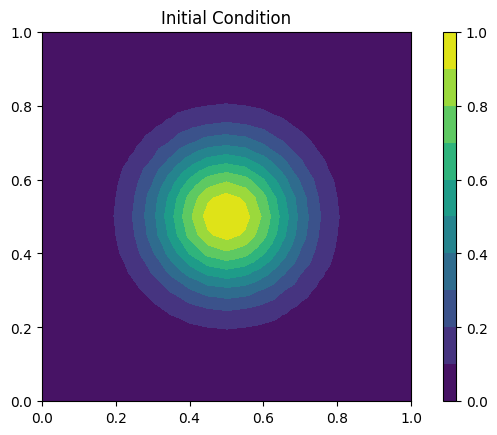

In [4]:
def plot_temp(T, title=None, Tmax=1, ax=None, colorbar=True):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    levels = np.linspace(0, Tmax, 11)
    with stop_annotating():
      c = tricontourf(T, axes=ax, levels=levels)
    ax.set_title(title)
    ax.set_aspect('equal')
    if colorbar:
        cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().y1-ax.get_position().y0])
        fig.colorbar(c, cax=cax)
plot_temp(T, 'Initial Condition', Tmax=1)

We run the model for twenty timesteps to ensure the entire Gaussian has left the domain. In this twin model we now checkpoint the solution at every timestep, so that we can later use it as the target boundary values.

In [5]:
with CheckpointFile('series.h5', 'w') as f:
    f.save_mesh(mesh)
    for i in range(20):
        f.save_function(T, idx=i)
        energy_solver.solve()
    # after saving idx=0, 19 at beginning of each timestep
    # we include idx=20 for the solution at the end of the final timestep
    f.save_function(T, idx=i)

  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear ImplicitMidpoint-EnergyEquation_stage0_ solve converged due to CONVERGED_ITS iterations 1
  Linear I

As expected the solution has completely disappeared:

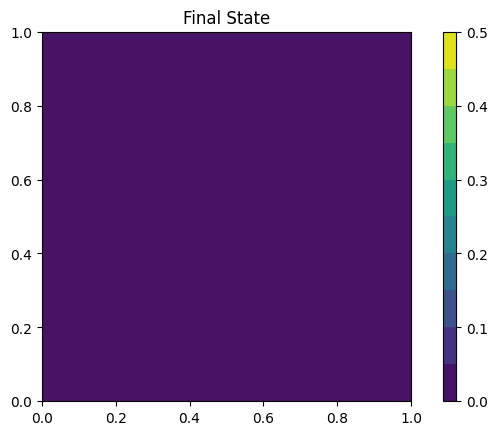

In [6]:
plot_temp(T, 'Final State', Tmax=.5)

## Advection Diffusion Model with Unknown Initial Condition
We now again set up the model where we do not know the initial condition, where we are now trying to find the optimal initial condition such that we closely match the recored outflow boundary values.

In [7]:
with CheckpointFile('series.h5', 'r') as f:
    mesh = f.load_mesh()

In [8]:
V = VectorFunctionSpace(mesh, "CG", 2)
Q = FunctionSpace(mesh, "CG", 1)
T = Function(Q, name='Temperature')

x, y = SpatialCoordinate(mesh)
u = interpolate(as_vector((-y, x)), V)
u.rename('Velocity')

approximation = BoussinesqApproximation(Ra=1, kappa=5e-2)
temp_bcs = {
    bottom: {'T': 0},
}
delta_t = .1
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)
# make it a bit quieter:
energy_solver.solver_parameters.pop('ksp_converged_reason')

As a first guess we use a Gaussian that is in the wrong place: centred around $(0.7, 0.7)$ instead of $(0.5, 0.5)$:

In [9]:
x0, y0 = 0.7, 0.7
w = .2
r2 = (x-x0)**2 + (y-y0)**2
Twrong = interpolate(exp(-r2/w**2), Q)

As in our first example, we make sure to clear the tape before our actual model starts and specify the control at the right stage. During the model we load back in the solutions from the twin model, but only use its values at the boundary to compute a mismatch with the current model as an integral over the left boundary. Note that we start calculating the functional already in the first timestep, and we keep on adding terms to it, all of this will still be automatically recorded by the pyadjoint tape.

In [10]:
tape = get_working_tape()
tape.clear_tape()

T.interpolate(Twrong)

# we want to vary the _initial_ (current) state of T
# here we specify the current state of T as the control
m = Control(T)

J = AdjFloat(0.0)
factor = AdjFloat(0.5)  # first and final boundary integral is weighted by 0.5
# to implement mid-point rule time-integration

with CheckpointFile('series.h5', 'r') as f:
    for i in range(20):
        T_target = f.load_function(mesh, 'Temperature', idx=i)
        J = J + factor * assemble((T-T_target)**2*ds(left))
        factor = 1.0  # remaing timesteps weighted by 1
        energy_solver.solve()
    
    T_target = f.load_function(mesh, 'Temperature', idx=i)
    # add final contribution weighted again by 0.5
    J = J + factor * assemble((T-T_target)**2*ds(left))

print(f"{J:.14f}")

0.06385961212364


We define the reduced functional using the final value of `J` and the specified control. This allows us to rerun the model with arbitrary initial condition. Again we first try to simply rerun the model with the same "wrong" initial condition.

In [11]:
Jhat = ReducedFunctional(J, m)

In [12]:
print(f"{Jhat(Twrong):.14f}")

0.06385919930808


Now try to rerun the model with "correct" initial condition from the twin experiment, and we see that indeed we end up with a near-zero misfit.

In [13]:
x0, y0 = 0.5, 0.5
w = .2
r2 = (x-x0)**2 + (y-y0)**2
T0 = interpolate(exp(-r2/w**2), Q)

In [14]:
print(f"{Jhat(T0):.14f}")

0.00001481456132


We can again look at the gradient, but this time the gradient is a lot less intuitive.

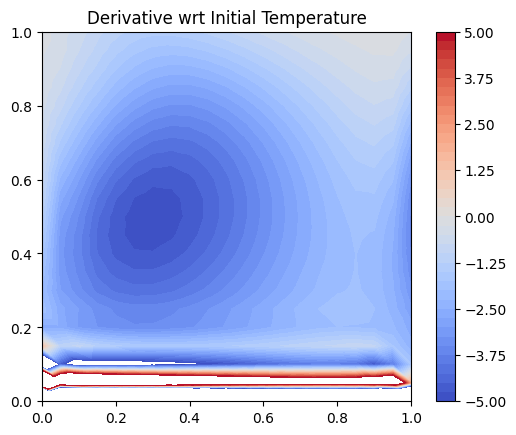

In [15]:
# evaluate the gradient around an initial guess of T=0 as the initial condition
T_init = Function(Q)
Jhat(T_init)

# ask for L2 Riesz representation to get grid-independent result
gradJ = Jhat.derivative(options={"riesz_representation": "L2"})

fig, ax = plt.subplots()
levels = np.linspace(-5, 5, 41)
from matplotlib import colors
cmap = plt.cm.coolwarm
with stop_annotating():
    c = tricontourf(gradJ, axes=ax, levels=levels, norm=colors.CenteredNorm(), cmap=cmap)
ax.set_title('Derivative wrt Initial Temperature')
ax.set_aspect('equal')
fig.colorbar(c);

## Invert for Optimal Initial Condition Using Gradient-Based Optimisation Algorithm
Finally, we again use L-BFGS-B to invert for the inital condition. We have last evaluated the reduced functional with a zero initial condition as the control value, so this will be our initial guess.

In [16]:
# create bounds of 0 and 1 enforced during optimisation
Tmin = Function(Q)
Tmax = Function(Q)
Tmax.assign(1)
T_opt = minimize(Jhat, method='L-BFGS-B', bounds=[Tmin, Tmax], tol=1e-5)

/home/skramer/firedrake/src/firedrake/firedrake/adjoint_utils/function.py:112: UserWarning: Could not find overloaded class of type '<class 'int'>'.
  other = create_overloaded_object(other)


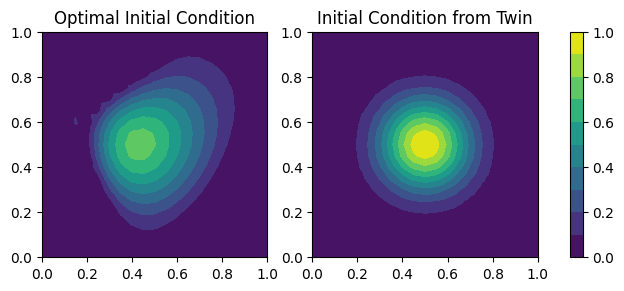

In [17]:
fig, ax = plt.subplots(1,2)
plot_temp(T_opt, 'Optimal Initial Condition', Tmax=1, ax=ax[0], colorbar=False)
plot_temp(T0, 'Initial Condition from Twin', Tmax=1, ax=ax[1])